<a href="https://colab.research.google.com/github/GreggHeller1/Adult-Spine-Models/blob/main/scripts/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#settings
%load_ext autoreload
%autoreload 2
try:
  import google.colab
  in_colab = True
except:
  in_colab = False
print(in_colab)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False


In [6]:
#installs (for colab only, run this once)
if in_colab:
    ! git clone https://github.com/GreggHeller1/Adult-Spine-Models.git

In [16]:
#local imports
#cwd if in colab for imports to work
if in_colab:
    %cd /content/Adult-Spine-Models
    
from src import data_io as io
from src import plotting as plot
from src import computation as comp
from src import helper_functions as hf
from src import config as cfg
from src import weight_generators
from src import inclusion_mask_generators
from src import integration_functions
from src import somatic_functions
from src import evaluation_functions
from src import trial_selection

In [8]:
#imports
import xarray as xr
#import pandas as pd
import numpy as np
import ipdb


from matplotlib import pyplot as plt

from PIL import Image #this needs to be after matplotlib??
from scipy.stats import stats   


import os
#from neuron import h, gui

In [5]:
#useful commands when setting up the repo
#############################

#jupytext --sync scripts/notebook.ipynb
# black scripts, black src, black tests
#should make a bat file for wip commit in dropbox - copy files and then push from there
#git commit -m “WIP: description of changes/current errors/still todo” (ommit WIP if code is running and tests are passing)
#    1. chmod +x path/to/file
# pip install -e .


#useful commands when working here
#############################

#import cProfile
#cProfile.run('out=func_call(args)')

#%pdb
#!pytest ../src/tests.py
#import pdb; pdb.set_trace() 
#!import code; code.interact(local=vars())

In [20]:
%pdb

Automatic pdb calling has been turned OFF


In [79]:
!pytest ../src/tests.py

============================= test session starts =============================
platform win32 -- Python 3.7.12, pytest-7.4.4, pluggy-1.2.0
rootdir: C:\Users\Gregg\Dropbox (MIT)\gregg_code\adult-spine-models
plugins: anyio-3.7.1
collected 7 items

..\src\tests.py .......                                                  [100%]

============================== warnings summary ===============================
..\..\..\..\anaconda3\envs\adult-spine-models\lib\site-packages\xarray\core\pycompat.py:37
..\..\..\..\anaconda3\envs\adult-spine-models\lib\site-packages\xarray\core\pycompat.py:37
..\..\..\..\anaconda3\envs\adult-spine-models\lib\site-packages\xarray\core\pycompat.py:37
  C:\Users\Gregg\anaconda3\envs\adult-spine-models\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
    duck_array_version = LooseVersion("0.0.0")

..\..\..\..\anaconda3\envs\adult-spine-models\lib\site-packages\setuptools\_dist

In [9]:
#define paths
#cwd if in colab for file loading to work
if in_colab:
    %cd /content/Adult-Spine-Models/scripts
    
test_path = os.path.join('demo_data', 'test.txt')
print(test_path)
print(os.getcwd())
print(os.path.exists(test_path))


#soma_path = "/Users/greggoryheller/code/Adult-Spine-Models/scripts/demo_data/ASC26_cell_3_soma.mat"
#spines_path = "/Users/greggoryheller/code/Adult-Spine-Models/scripts/demo_data/ASC26_cell_3_spines.mat"
#spines_path = "/Users/Gregg/Dropbox (MIT)/2021 Gregg Sur rotation/ASC_experimental_data/2022-11 Soma Data/ASC15.mat"
soma_path = r"C:\Users\Gregg\Dropbox (MIT)\2021 Gregg Sur rotation\ASC_experimental_data\2023-08 Soma Data\ASC24.mat"
spines_path = r"C:\Users\Gregg\Dropbox (MIT)\2021 Gregg Sur rotation\ASC_experimental_data\2023-08 Spine Data\ASC24.mat"
print(os.path.exists(soma_path))
print(os.path.exists(spines_path))

demo_data\test.txt
c:\Users\Gregg\Dropbox (MIT)\gregg_code\adult-spine-models\scripts
False
True
True


In [10]:
#data inputs
#io.readfile(test_path)
soma = io.loadmat(soma_path)
spine_data = io.loadmat(spines_path)
soma_data = soma

In [11]:
data_xr, spines_per_fov_list = comp.compile_spine_traces(spine_data)
model_traces = data_xr.sum(dim='spines')
print(type(model_traces))
print(model_traces.dims)
print(model_traces.coords)
print(model_traces.shape)

soma_traces = comp.get_soma_traces(soma_data)
print(type(soma_traces))
print(soma_traces.shape)

AttributeError: module 'src.computation' has no attribute 'compile_spine_traces'

In [14]:
model_spec_df = cfg.run_model_specs

In [37]:
def generate_weight_matricies(model_spec_df, spine_data):

           #### Get weight matricies for each model we want to test
            print("###########################################################")
            print('')
            print('Generating weight matricies for each model')

            weight_matricies_dict = {}
            all_weightings = list(model_spec_df['weighted_by'])+list(model_spec_df['inclusion_based_on'])
            
            #commenting these out to do them in order for now
            #unique_weightings = all_weightings
            unique_weightings = set(all_weightings)
            unique_weightings = {x for x in unique_weightings if x==x} #remove nans
            unique_weightings.remove('_')
            for weight_name in unique_weightings:
                func_name = f'weights_from_{weight_name}'
                print('func_name', func_name)
                try:
                    weight_func = getattr(weight_generators, func_name)
                except AttributeError as E:
                    #If we are not rescaling the values for the weighting (applying a weight function to the retrieved values)
                    #Then we can pull the values directly using the get_fovs_attr functions in hf and the default weight_identity
                    #Probably we should specify this in the model_specifications.csv, or even precompute and save in a seperate module. 
                    #we should definitely save the weightiings we used.
                    func_name = f'get_fovs_{weight_name}'
                    param_func = getattr(hf, func_name)
                    print('func_name', func_name)
                    def weight_func(spine_data):
                        return weight_generators.get_weight_array(spine_data, param_func)
                    #weight_func = weight_generators.get_weight_array(spine_data, param_func)
                weights = weight_func(spine_data)
                #print('weights', weights)
                weight_matricies_dict[weight_name] = weights
                print(weight_name)
                print(weights)

generate_weight_matricies(model_spec_df, spine_data)


c:\users\gregg\dropbox (mit)\gregg_code\adult-spine-models\src\weight_generators.py:51: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  weight_array = np.array(weight_iterable)
c:\users\gregg\dropbox (mit)\gregg_code\adult-spine-models\src\weight_generators.py:52: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  print(weight_array)


###########################################################

Generating weight matricies for each model
func_name weights_from_corr_to_nearest_resp_spine
func_name get_fovs_corr_to_nearest_resp_spine
corr_to_nearest_resp_spine
[0.41773343 0.21964328 0.21964328 0.24515401 0.24515401 0.21964328
 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328
 0.21964328 0.21964328 0.21964328 0.21964328 0.06598841 0.21964328
 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328 0.23528762
 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328
 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328 0.5783382
 0.21964328 0.5783382  0.21964328 0.21964328 0.21964328 0.21964328
 0.28928256 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328
 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328
 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328 0.21964328
 0.21964328 0.21964328 0.34335306 0.34335306 0.21964328 0.898275
 0.21964328 0.21964328 0.21964328 0.219

-958.7329683340355


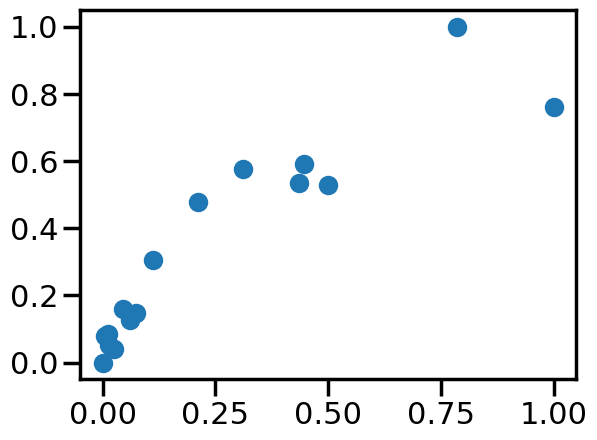

In [112]:
m_tuning_curve, model_max_amplitude = comp.compute_normalized_tuning_curves(model_traces)
s_tuning_curve, soma_max_amplitude = comp.compute_normalized_tuning_curves(soma_traces)
#m_tuning_curve = comp.compute_tuning_curves(model_traces)
#s_tuning_curve = comp.compute_tuning_curves(soma_traces)
plt.scatter(m_tuning_curve, s_tuning_curve)
print(comp.stim_on_llikelihood(model_traces, soma_traces))

In [87]:
comp.stim_on_neg_llikelihood(model_traces, soma_traces)

958.7329683340355

In [115]:
simulated_output_of_soma, best_score, fit_params = comp.somatic_2_param_lin(model_traces, soma_traces, score_function=comp.stim_on_neg_llikelihood)

type(simulated_output_of_soma)

xarray.core.dataarray.DataArray

-136.2314836285595


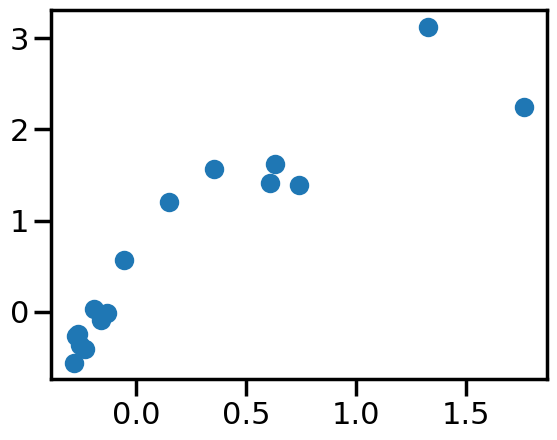

In [116]:

m_tuning_curve = comp.compute_tuning_curves(simulated_output_of_soma)
s_tuning_curve = comp.compute_tuning_curves(soma_traces)
print(comp.stim_on_llikelihood(simulated_output_of_soma, soma_traces))
plt.scatter(m_tuning_curve, s_tuning_curve)

In [78]:
n_traces = comp.normalize_traces_by_tuning_curve(soma_traces)
print(np.max(soma_traces))
print(np.max(n_traces))
tuning_curve = comp.compute_tuning_curves(soma_traces)
print(np.min(tuning_curve))
tuning_curve = comp.compute_tuning_curves(n_traces)
print(np.min(tuning_curve))
print(tuning_curve)

13.646200455672611
11.228302454110258
-0.3429016049015234
-4.9873299934333204e-18
[ 1.00000000e+00  4.66728083e-01  4.82048068e-01  7.24107156e-02
  3.25281565e-01  7.74732998e-01 -4.98732999e-18  3.84677703e-01]


0.1118450592815701


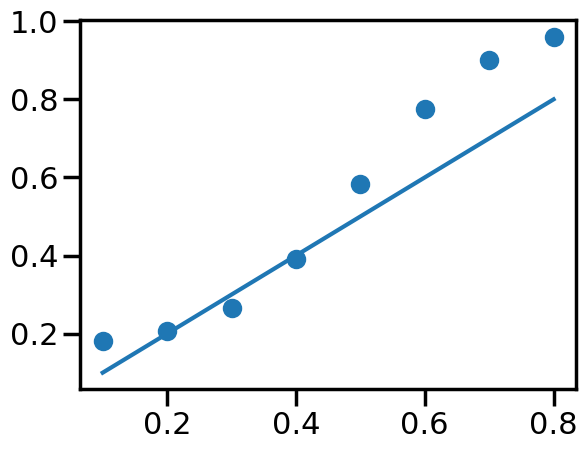

In [45]:
#testing out the fitting functions
a = np.array([.1,.2,.3,.4,.5,.6,.7,.8])
b = comp.somatic_sigmoid_fit([.5,.1,.02], a)

plt.plot(a, a*1)
plt.scatter(a, b)
def my_score_function(a, b):
    return np.sum((a-b)**2)
print(my_score_function(a, b))


In [47]:
comp.apply_error_func([.5,.1,.02], comp.somatic_sigmoid_fit, a, b, score_function=my_score_function)

0.0

In [49]:
score, guessed_params = comp.somatic_3_param_sigmoid(a, b, score_function=my_score_function)
print(score, guessed_params)

0.0 [0.5  0.1  0.02]


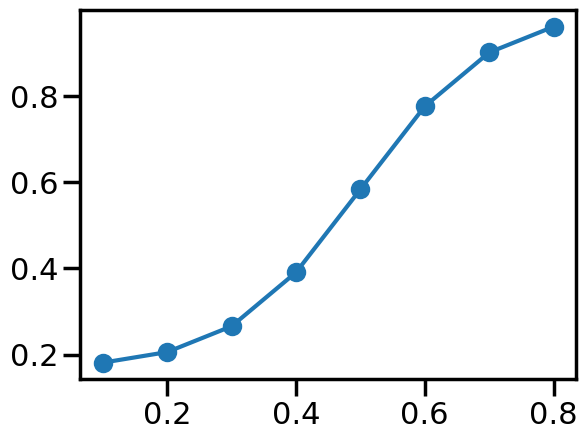

In [51]:
ys = comp.somatic_sigmoid_fit(guessed_params, a)
plt.plot(a, ys)
plt.scatter(a, b)

In [69]:
dummy_model_samples_uniform = [1,2]*5#[1,2,3,4,5,6,7,8,9,11]*10
model_samples = dummy_model_samples_uniform
actual_samples=1
len(dummy_model_samples_uniform)

10

In [68]:
print(np.log(1/10))
#np.isclose(np.log(10), 
comp.compute_loglikelihood(model_samples, [1.5], method='kde')

-2.3025850929940455


-47.923206259650684

In [103]:


comp.stim_on_llikelihood(model_traces, soma_traces)

-732.0619736658127

In [98]:
comp.stim_on_llikelihood(model_traces, model_traces)

-717.6908017446515

In [50]:
for i, (fov_activity, fov_metadata )in enumerate(hf.fov_generator(spine_data)):
        print(len(hf.spine_reliability(fov_activity, fov_metadata)))

17
8
24


In [78]:
soma_traces = hf.get_traces(soma_data)
soma_traces.shape

(16, 10, 91)

In [ ]:
np.histogramdd(soma_traces, bins = (5, 8, ))

In [81]:
soma_traces = hf.get_traces(soma_data)
soma_traces.shape
#init_traces_xarray(soma_traces, simulated_trials_per_stim)

(16, 10, 91)

In [82]:
#data manipulation
spines = spine_data
type(spines)
print(spines[0].shape)


print(soma[3])
print(spines['dend_cell'])

#print(np.shape(soma['soma_cell']))
#print(np.shape(spines['dend_cell']))



#print(soma['soma_cell'][0,3]._fieldnames)


TypeError: Accessing a group is done with bytes or str, not <class 'int'>

In [83]:
#print(spines.keys())
#print(np.shape(soma[3]))
#print(soma[3].keys())


soma_field_2 = io._todict(soma[2])

spine_field_2 = io._todict(spines[2])
#ref = spine_field_2['dend_cell'][2,0]
#spine_field_2 = spines[ref]#['DSI']

#print(np.array(field_2))
#print(field_2['vis_stim_times'])

#spines_f2 = 


TypeError: Accessing a group is done with bytes or str, not <class 'int'>

In [20]:
print(spine_field_2['trial_traces'].shape)

(16, 10, 92)


In [84]:
soma_traces = np.array(soma_field_2['trial_traces'])
spine_traces = np.array(spine_field_2['trial_traces'][:,:,0,:,0].swapaxes(0,-1))

fovs = spine_data['dend_cell'][2,:].shape[0]
print(fovs)

print(soma_traces.shape)
print(spine_traces.shape)


#trial_amps = np.array(field_2['trial_amp'])
#print(trial_amps.shape)

NameError: name 'spine_field_2' is not defined

In [22]:
soma_traces = hf.get_traces(soma_data)
spine_traces = hf.get_traces(spine_data)

In [24]:
metadata = hf.get_spine_metadata(spine_data, fov_num = 0)
#print(len(hf.get_neck_length(spine_data)['stem_stats']))

In [25]:
fov_activity = spine_field_2
fov_metadata = metadata

In [30]:
fov_activity['responsive']

1

In [38]:
soma_sub_traces = comp.select_timesteps(soma_traces)

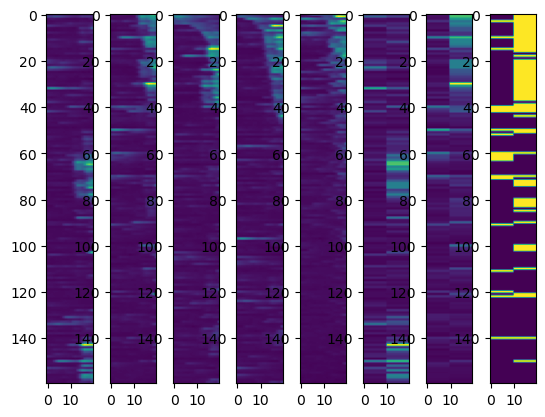

In [39]:
plot.plot_activity_plots(soma_sub_traces)

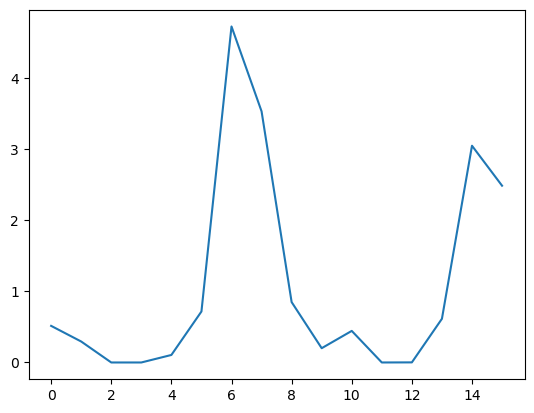

In [40]:
plt.plot(hf.get_precomputed_tuning_curve(soma_data))

In [48]:
summed_spine_traces_1 = comp.get_summed_trial_sampled_spine_trace(spine_data)
sum_spine_sub_traces = comp.select_timesteps(summed_spine_traces_1)

AttributeError: module 'src.computation' has no attribute 'get_summed_trial_sampled_spine_trace'

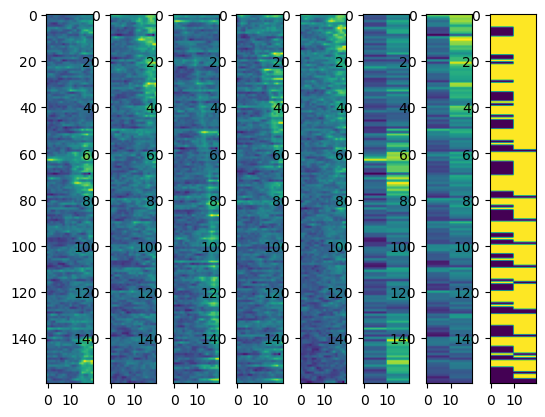

In [42]:
plot.plot_activity_plots(sum_spine_sub_traces)

In [43]:
import cProfile
cProfile.run('summed_spine_traces = comp.get_summed_trial_sampled_spine_trace(spine_data)')

#summed_spine_traces = comp.get_summed_trial_sampled_spine_trace(spine_data)
sum_spine_sub_traces = comp.select_timesteps(summed_spine_traces)

         3 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




AttributeError: module 'src.computation' has no attribute 'get_summed_trial_sampled_spine_trace'

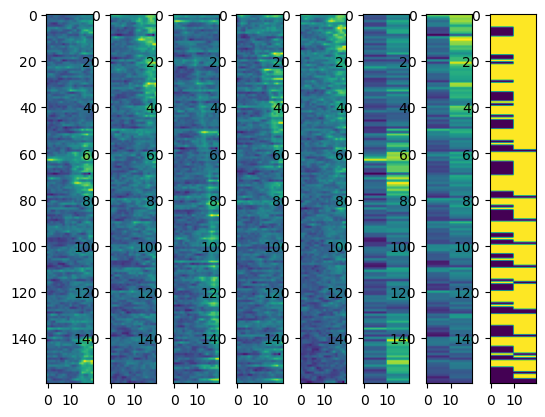

In [45]:
plot.plot_activity_plots(sum_spine_sub_traces)

(16,)


NameError: name 'summed_spine_traces' is not defined

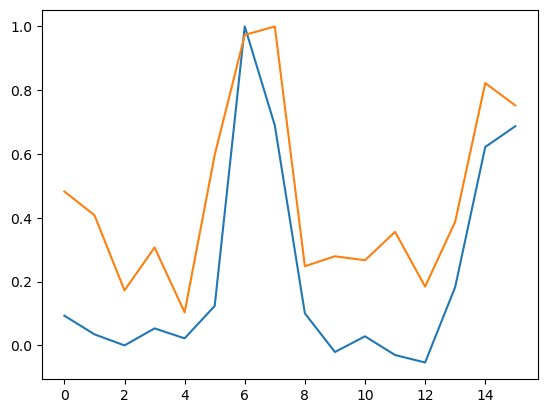

In [55]:
means = comp.compute_tuning_curve(soma_traces)
print(means.shape)
soma_means = means/max(means)
plt.plot(soma_means, label='measured soma response')
means = comp.compute_tuning_curve(summed_spine_traces_1)
means = means/max(means)

plt.plot(means, label='sum spines')
means = comp.compute_tuning_curve(summed_spine_traces)
sampled_means = means/max(means)

plt.plot(sampled_means, label='sum sampled spines')

plt.plot(hf.get_precomputed_tuning_curve(soma_data), label='kyles')
plt.legend()
print(f'{stats.pearsonr(soma_means, sampled_means)}')

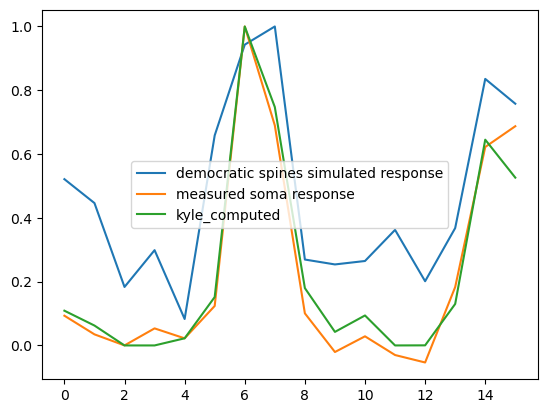

In [138]:
all_spine_activity_array, spines_per_fov_list = comp.compile_spine_traces(spine_data)

model_output = comp.compute_model_output_from_random_sampled_fovs(spine_data, all_spine_activity_array, spines_per_fov_list, simulated_trials_per_stim=100)
means = comp.compute_tuning_curve(model_output)
means = means/max(means)
plt.plot(means, label='democratic spines simulated response')
plt.plot(soma_means, label='measured soma response')




kyle_means = hf.get_precomputed_tuning_curve(soma_data)
#mean_amp should be mean of all the trials
#excluded trials where the baseline was elevated
#trial amps is mean of stim on - mean o baseline, then average
#stim on is 41-50 (0-.9)
#baseline is 21-40 (-2:-.1)

#also median and von mieses



kyle_means = kyle_means/max(kyle_means)
plt.plot(kyle_means, label = 'kyle_computed')

plt.legend()


In [ ]:
#plot.plot_activity_plots(np.array(model_output))
plt.imshow(plot.flatten_for_image(np.array(model_output)), aspect='auto')

In [ ]:
plt.imshow(plot.flatten_for_image(soma_traces), aspect='auto')

In [ ]:

weighted_traces = comp.weights_size_lin(spine_data, all_spine_activity_array)


weighted_traces.shape

spine = 1
stim = 6
pres = 0
plt.plot(weighted_traces[spine,stim,pres,:])
plt.plot(all_spine_activity_array[spine,stim,pres,:])


In [226]:

all_spine_activity_array, spines_per_fov_list = comp.compile_spine_traces(spine_data, subset='unresponsive')

unresponsive_model_output = comp.compute_model_output_from_random_sampled_fovs(spine_data,
    all_spine_activity_array, spines_per_fov_list, simulated_trials_per_stim=100,
)
unresponsive_means = comp.compute_tuning_curve(unresponsive_model_output)
unresponsive_means = unresponsive_means/max(unresponsive_means)

all_spine_activity_array, spines_per_fov_list = comp.compile_spine_traces(spine_data, subset='responsive')


responsive_model_output = comp.compute_model_output_from_random_sampled_fovs(spine_data,
    all_spine_activity_array, spines_per_fov_list, simulated_trials_per_stim=100,
)
responsive_means = comp.compute_tuning_curve(responsive_model_output)
responsive_means = responsive_means/max(responsive_means)


[ 0  1  2  3  8  9 12]
[ 0  1  3  6  9 10]
[ 2  3  4  5  8 10 14 15 16]
[ 0  1  2  3  4  5  6  7  9 10]
[0 2 3 5]
[ 0  1  3  5  6  8  9 11 12]
[ 0  1  2  4  5  7  8 11 12 13 14]
[ 0  1  2  3  4  5  8 11]
[0 1 2 3 4 5 6 7]
[ 3  5  6 11 12]
[1 2 3 4 5]
####
[ 4  5  6  7 10 11 13]
[ 2  4  5  7  8 11]
[ 0  1  6  7  9 11 12 13]
[ 8 11]
[1 4 6 7 8]
[ 2  4  7 10]
[ 3  6  9 10 15]
[ 6  7  9 10 12]
[8 9]
[ 0  1  2  4  7  8  9 10 13]
[0]
####


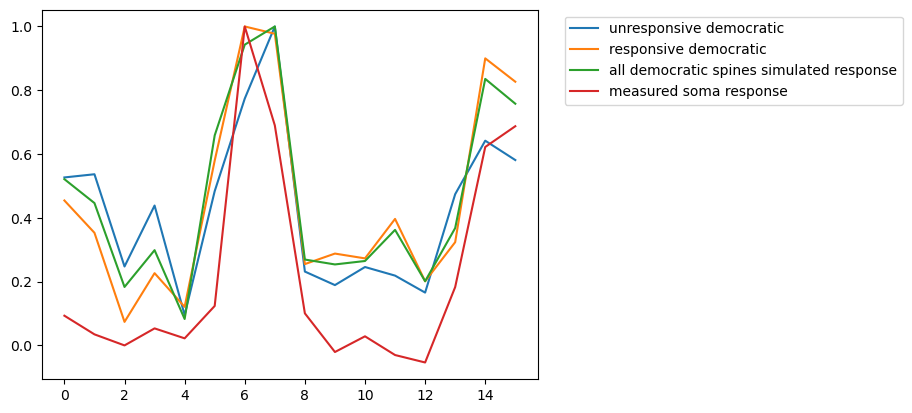

In [227]:

plt.plot(unresponsive_means, label='unresponsive democratic')

plt.plot(responsive_means, label='responsive democratic')

plt.plot(means, label='all democratic spines simulated response')
plt.plot(soma_means, label='measured soma response')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

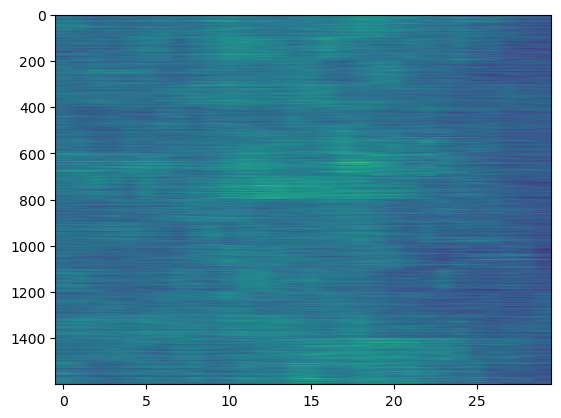

In [229]:
selected_timesteps = comp.select_timesteps(np.array(unresponsive_model_output))
new_idx = plot.sort_by_onset_time(selected_timesteps)#, plot.sort_by_mean_amp)
ordered_traces = plot.use_as_index(new_idx, selected_timesteps)

#plt.imshow(ordered_traces, aspect='auto')
plt.imshow(plot.flatten_for_image(selected_timesteps), aspect='auto')

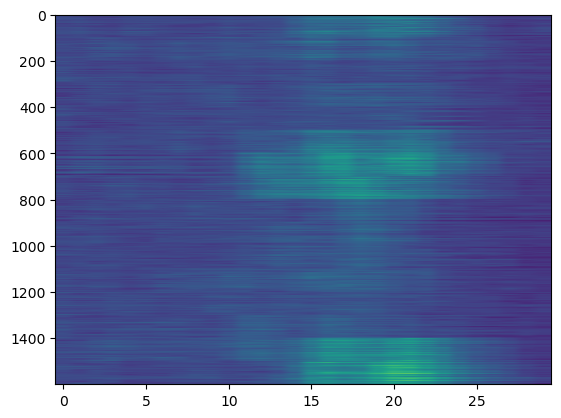

In [230]:
selected_timesteps = comp.select_timesteps(np.array(responsive_model_output))
new_idx = plot.sort_by_onset_time(selected_timesteps)#, plot.sort_by_mean_amp)
ordered_traces = plot.use_as_index(new_idx, selected_timesteps)

#plt.imshow(ordered_traces, aspect='auto')
plt.imshow(plot.flatten_for_image(selected_timesteps), aspect='auto')

In [ ]:
all_spine_activity_array, spines_per_fov_list = comp.compile_spine_traces(spine_data)

size_model_output = comp.compute_model_output_from_random_sampled_fovs(spine_data,
    all_spine_activity_array, spines_per_fov_list, simulated_trials_per_stim=100,
    weight_function = comp.weights_size_lin
)
size_means = comp.compute_tuning_curve(size_model_output)
size_means = size_means/max(size_means)

dist_model_output = comp.compute_model_output_from_random_sampled_fovs(spine_data,
    all_spine_activity_array, spines_per_fov_list, simulated_trials_per_stim=100,
    weight_function = comp.weights_distance_lin
)
dist_means = comp.compute_tuning_curve(dist_model_output)
dist_means = dist_means/max(dist_means)

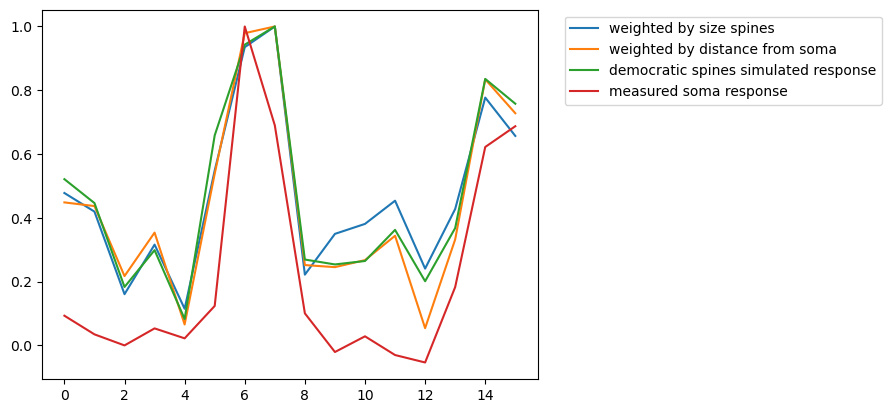

In [140]:

    
plt.plot(size_means, label='weighted by size spines')

plt.plot(dist_means, label='weighted by distance from soma')

plt.plot(democratic_means, label='democratic spines simulated response')
plt.plot(soma_means, label='measured soma response')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

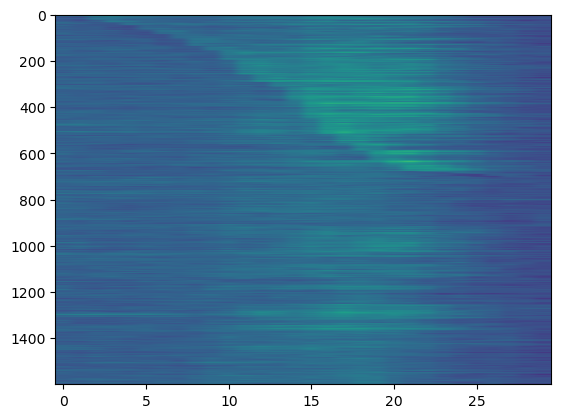

In [234]:
selected_timesteps = comp.select_timesteps(np.array(size_model_output))
new_idx = plot.sort_by_onset_time(selected_timesteps)#, plot.sort_by_mean_amp)
ordered_traces = plot.use_as_index(new_idx, selected_timesteps)

plt.imshow(ordered_traces, aspect='auto')
#plt.imshow(plot.flatten_for_image(selected_timesteps), aspect='auto')

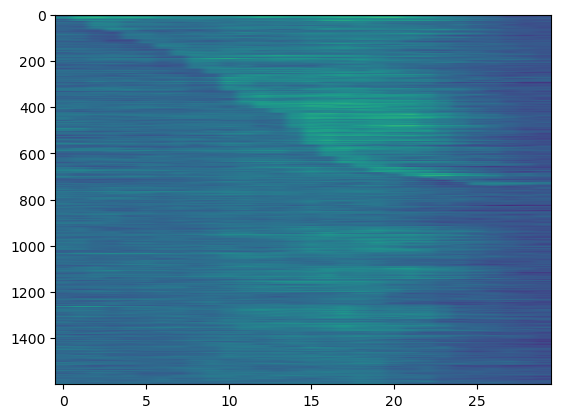

In [103]:
selected_timesteps = comp.select_timesteps(np.array(dist_model_output))
new_idx = plot.sort_by_onset_time(selected_timesteps)#, plot.sort_by_mean_amp)
ordered_traces = plot.use_as_index(new_idx, selected_timesteps)

plt.imshow(ordered_traces, aspect='auto')
#plt.imshow(plot.flatten_for_image(selected_timesteps), aspect='auto')

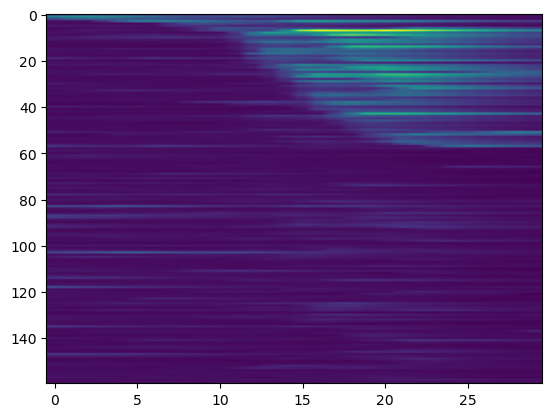

In [122]:
selected_timesteps = comp.select_timesteps(soma_traces)
new_idx = plot.sort_by_onset_time(selected_timesteps)#, plot.sort_by_mean_amp)
ordered_traces = plot.use_as_index(new_idx, selected_timesteps)

plt.imshow(ordered_traces, aspect='auto')
#plt.imshow(plot.flatten_for_image(selected_timesteps), aspect='auto')

In [166]:
a = np.zeros((136, 16, 10, 91))
print(a.shape)
b = np.arange(0, a.shape[0], 1)
print(len(b))
c = np.random.randint(0,9, len(b))
print(c)
#lets try to grab the 1st presentation for spine 1 and the second for spine 2
sliced = a[b, :, c, :]
print(sliced.shape)

(136, 16, 10, 91)
136
[0 7 2 5 5 5 4 0 0 3 6 1 8 1 4 3 8 4 7 7 2 7 1 5 1 1 7 4 4 7 1 5 2 2 8 5 8
 5 3 0 1 4 6 8 4 1 3 7 6 7 4 4 6 7 3 1 2 5 8 0 1 4 3 8 1 8 4 0 2 8 0 2 8 0
 0 5 6 0 5 5 2 3 3 1 5 8 4 1 5 0 6 5 3 0 4 1 7 8 0 4 4 1 2 7 0 3 8 8 8 1 7
 0 2 8 5 6 7 8 1 3 7 6 7 1 7 4 7 0 3 7 4 4 2 4 6 3]
(136, 16, 91)


In [61]:
a = np.array([[1,2,3,4,5,6], [7,8,9,10,11,12]])
print(a.shape)
a[(1,0,1,0,1,0), (0,1,2,3,4,5)]

(2, 6)


array([ 7,  2,  9,  4, 11,  6])

In [19]:
spine_sub_traces = comp.select_timesteps(spine_traces)
print(spine_traces.shape)
print(spine_sub_traces.shape)

(16, 10, 91)
(16, 10, 20)


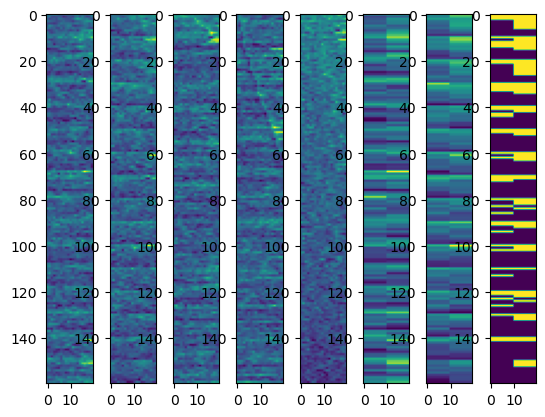

In [20]:
plot.plot_activity_plots(spine_sub_traces)

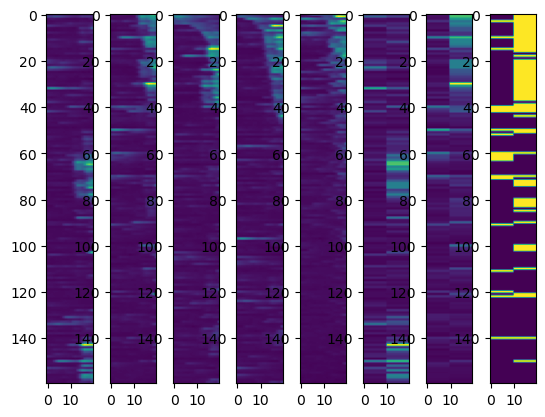

In [21]:
plot.plot_activity_plots(soma_sub_traces)

In [232]:
all_spine_activity_array, spines_per_fov_list = comp.compile_spine_traces(spine_data, subset='all')

zeta_list = []
for i, (fov_activity_meta, fov_metadata )in enumerate(hf.fov_generator(spine_data)):
    zeta_list.extend(list(hf.get_fov_zetas(fov_activity_meta)))

similarity_list, spine_num_list = plot.get_most_similar_spine(soma_data, all_spine_activity_array)
#spine_means, spine_means_sorted, spine_bool = plot.produce_activity_plots(best_match_traces)  
responsive_idxs = list(np.where(np.array(zeta_list) <=.05)[0])
responsive_ranks = []
for i, spine_idx in enumerate(spine_num_list):
    if spine_idx in responsive_idxs:
        responsive_ranks.append(i)
print(responsive_ranks)

unresponsive_idxs = list(np.where(np.array(zeta_list) >.05)[0])
unresponsive_ranks = []
for i, spine_idx in enumerate(spine_num_list):
    if spine_idx in unresponsive_idxs:
        unresponsive_ranks.append(i)
print(unresponsive_ranks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2 3 4 5 6 7 8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[0 1 2 3 4 5]
####
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 18, 21, 23, 26, 28, 31, 32, 33, 36, 37, 39, 40, 42, 47, 50, 62, 73, 74, 80, 83, 84, 85, 86, 87, 94, 95, 97, 101, 103, 111, 113, 115, 120, 122, 126, 129, 132, 134, 135]
[6, 11, 15, 17, 19, 20, 22, 24, 25, 27, 29, 30, 34, 35, 38, 41, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 75, 76, 77, 78, 79, 81, 82, 88, 89, 90, 91, 92, 93, 96, 98, 99, 100, 102, 104, 105, 106, 107, 108, 109, 110, 112, 114, 116, 117, 118, 119, 121, 123, 124, 125, 127, 128, 130, 131, 133]


global spine_num: 19, this is the 5th spine in fov 1
global spine_num: 101, this is the 8th spine in fov 7
global spine_num: 47, this is the 4th spine in fov 3
global spine_num: 17, this is the 3th spine in fov 1
global spine_num: 0, this is the 0th spine in fov 0
global spine_num: 8, this is the 8th spine in fov 0
global spine_num: 45, this is the 2th spine in fov 3
global spine_num: 97, this is the 4th spine in fov 7
global spine_num: 41, this is the 15th spine in fov 2
global spine_num: 132, this is the 2th spine in fov 10


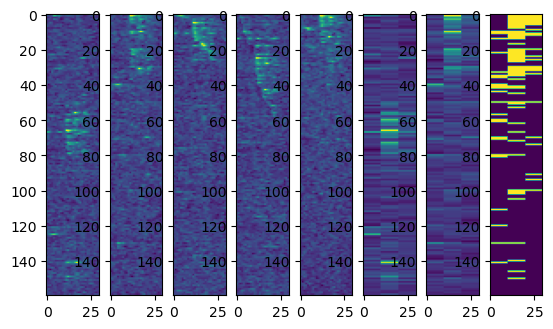

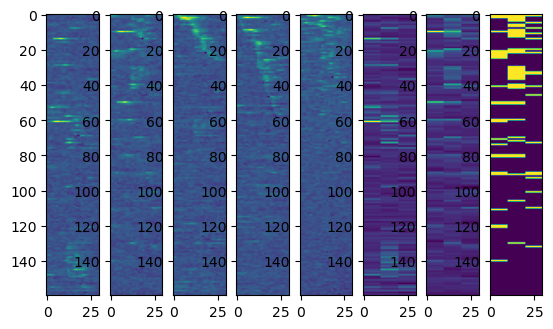

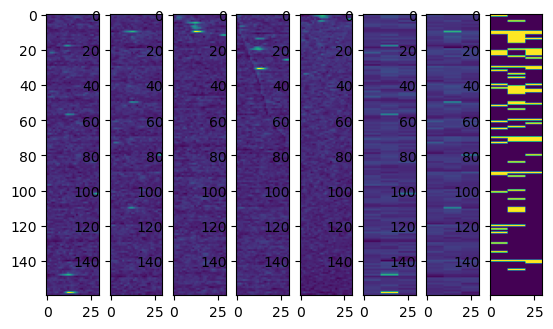

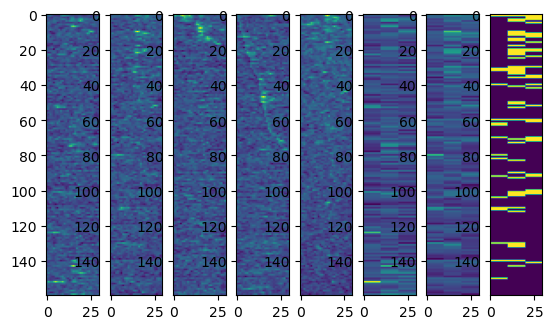

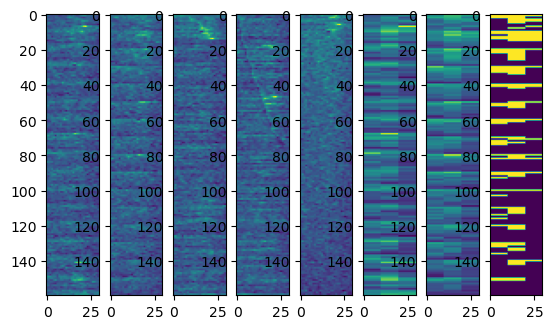

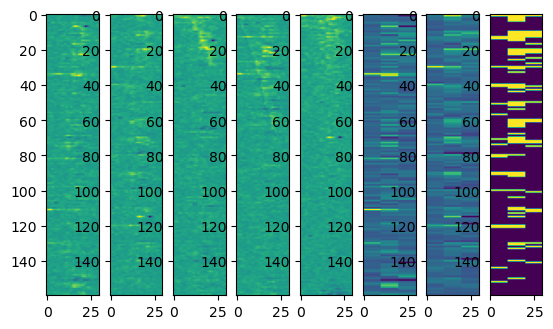

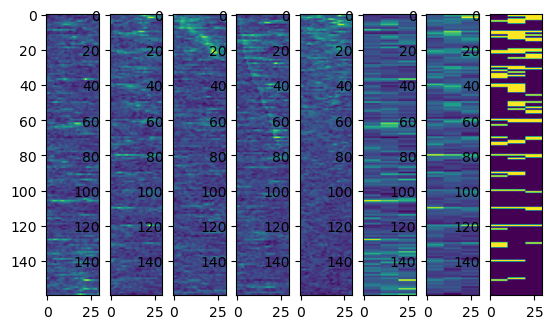

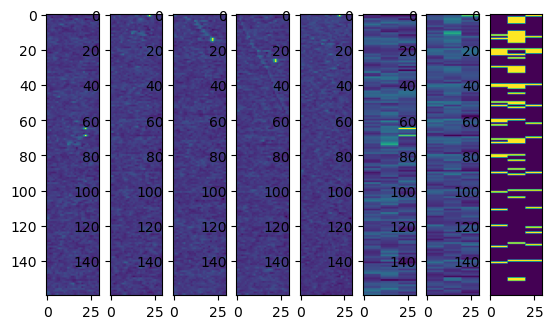

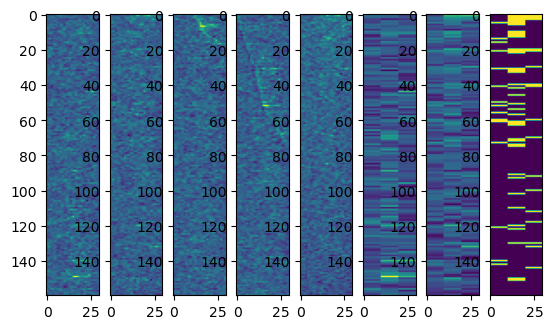

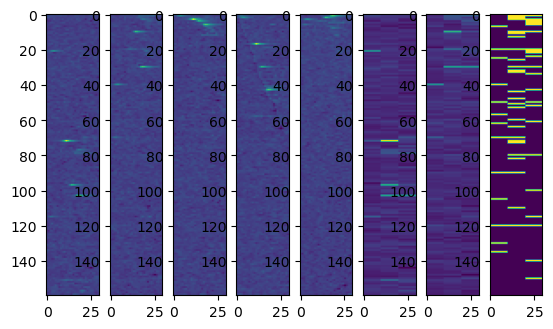

In [233]:
#for rank in range(10):
for rank in unresponsive_ranks[:10]:
#for rank in responsive_ranks[:10]:
    #best_match_traces = comp.get_traces(spine_data, fov=fov_num_list[rank], spine_index=spine_num_list[rank])
    best_match_traces = comp.select_timesteps(all_spine_activity_array[spine_num_list[rank],:,:,:])
    global_spine_num = spine_num_list[rank]
    (fov_i, spine_fov_i) = hf.get_fov_idx_from_all_spine_idx(global_spine_num, spine_data)
    print(f'global spine_num: {global_spine_num}, this is the {spine_fov_i}th spine in fov {fov_i}')
    plot.plot_activity_plots(np.array(best_match_traces))

In [ ]:
stim_repeats = 10


np.random.randint(0,stim_repeats, (3,4,5))

In [ ]:
fov = 0
type(fov) is int

In [31]:
a = np.array([0,0,2,0,0,0,1,0,0,0,0,0,0,3,0,0])

In [32]:
np.roll(a, -(np.argmax(a)-7))

array([1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0])

In [33]:
-4%16

12

In [43]:
import matplotlib.colors as cm

In [46]:
num_cells = 20
responsive_colors = [ plt.get_cmap('autumn')(x) for x in np.linspace(0, 1, num_cells)]
unresponsive_colors = [ plt.get_cmap('winter')(x) for x in np.linspace(0, 1, num_cells)]
#From here https://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib 

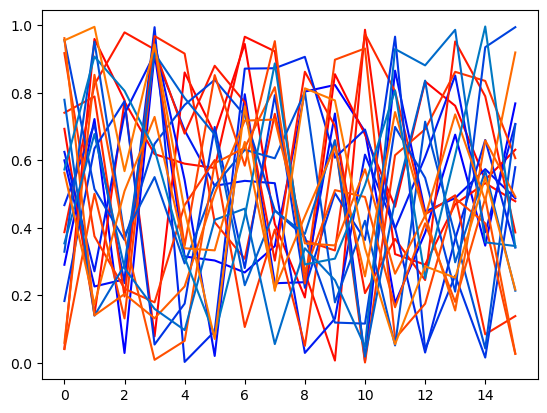

In [47]:
responsive_count = 0
unresponsive_count = 0
for i in range(num_cells):
    data = np.random.random(16)
    if i%2:
        color_val = responsive_colors[responsive_count]
        responsive_count+=1
    else:
        color_val = unresponsive_colors[unresponsive_count]
        unresponsive_count+=1
    plt.plot(data, color=color_val)

In [54]:
soma_field_2 = io._todict(soma_data[2])
tuning_curve = hf.get_precomputed_tuning_curve(soma_data)
preferred_stim_index = np.argmax(tuning_curve)
zeta_results = soma_field_2['ZETA_test_dir'][preferred_stim_index]
p_value = io._todict(zeta_results)['dblP']

In [55]:
print(p_value)

0.0012209905874881466


In [151]:
from scipy import stats
from PIL import Image
import imageio

/Users/Gregg/code/Adult-Spine-Models/src/config.py:51: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((end_s-start_s)%seconds_per_bin==0, 'The time range must be evenly divisible by the bin size')


In [61]:
stats.pearsonr([1,2,3], [4,5,6])


PearsonRResult(statistic=0.9999999999999998, pvalue=1.3415758552508151e-08)

In [166]:
test_array = np.random.randint(0,200,(16,16))
test_array = np.random.rand(16,16)#*30
data = test_array
path = 'demo_data/my_image.tiff'
img1 = Image.fromarray(data)
img1.save(path)
test_read = np.array(Image.open(path))

#f1 = list(img1.getdata())
#f2 = list(img2.getdata())
#print(f1 == f2)
#print(f1)

#test_array = np.tile(test_array,(3,1,1))
#test_array = np.moveaxis(test_array,0, 2)
#print(test_array.shape)
#im_pil = Image.fromarray(test_array)
##from here https://stackoverflow.com/questions/71272571/cant-recover-the-same-numpy-array-from-pil-saved-png-image
#path = 'demo_data/my_image.Tiff'
#im_pil.save(f, 'TIFF')
#plt.imsave(path, test_array, cmap=plt.cm.gray)

In [167]:
with Image.open(path) as im:
        test_read = np.array(im)
test_read.shape

(16, 16)

In [168]:
test_read[0,:]

array([ 2.1552205,  5.1438   ,  3.8143601, 18.655315 , 16.115036 ,
       10.827108 , 27.535976 ,  6.524315 , 17.183922 ,  6.253901 ,
       15.734637 , 19.458038 , 14.564917 , 10.392739 ,  0.4683412,
       11.050704 ], dtype=float32)

In [169]:
test_array[0,:]

array([ 2.15522059,  5.14379987,  3.81436011, 18.65531625, 16.11503582,
       10.82710822, 27.53597722,  6.52431511, 17.18392107,  6.25390081,
       15.73463764, 19.45803839, 14.56491649, 10.39273956,  0.46834119,
       11.05070358])

In [7]:
import pandas as pd
import seaborn as sns


In [10]:
fullpath = "/Users/Gregg/Dropbox (MIT)/2021 Gregg Sur rotation/ASC_experimental_data/adult_spine_model_results/single_neuron_simulation_scores.csv"
df = pd.read_csv(fullpath, index_col=0)
df.head()

experiment_id        model_type  model_correlation_to_soma_r  \
0  ASC18 cell 2        democratic                    -0.003663   
1  ASC18 cell 2        spine_size                     0.014303   
2  ASC18 cell 2  distance_to_soma                    -0.026346   
3  ASC18 cell 2      unresponsive                     0.002488   
4  ASC18 cell 2        responsive                    -0.265595   

   model_correlation_to_soma_p  model_soma_similarity_score responsive_status  
0                     0.989259                     0.127735      unresponsive  
1                     0.958073                     0.144695      unresponsive  
2                     0.922845                     0.129383      unresponsive  
3                     0.992704                     0.131316      unresponsive  
4                     0.320120                     0.130932      unresponsive

In [12]:
data = {'group': [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
        'block': [1, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3],
        'cond': ['c1', 'c2', 'c1', 'c2', 'c1', 'c2', 'c1', 'c2', 'c1', 'c2', 'c1', 'c2'],
        'value': [1, 2, 1.2, 2.1, 1.1, 2.2, 3, 4, 3.3, 4.1, 3.1, 4]}
df_2=pd.DataFrame(data)
df_2.head()

group  block cond  value
0      1      1   c1    1.0
1      1      1   c2    2.0
2      1      2   c1    1.2
3      1      2   c2    2.1
4      1      3   c1    1.1

In [ ]:
sns.lineplot(data=df.loc[df['unrespons'] == 1], x='block', y='value', hue='cond',
             palette='Blues', marker='o')
sns.lineplot(data=df.loc[df['group'] == 2], x='block', y='value', hue='cond',
             palette='Reds', marker='o')

## Get the legend handles and add them to plt.legend, so that the right handles are addigned
legend_handles, _= plt.gca().get_legend_handles_labels()
plt.legend(handles = legend_handles, title='Legend', loc='right',
           labels=['Group 1: C1', 'Group 1: C2', 'Group 2: C1', 'Group 2: C2'])
plt.show()